In [1]:
import numpy as np

import gif
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import matplotlib.ticker as ticker
import matplotlib.colors as colors

import seaborn as sns

sns.set_style("darkgrid")

In [3]:
B_stop = 4

low = 0.5
high = 7

######################################

x_cts = np.linspace(-1,1,1000)
low_freq = np.sin(2*np.pi*low*x_cts)
high_freq = np.sin(2*np.pi*high*x_cts)

total_sig = low_freq + high_freq

ideal_filt = 2*B_stop * np.sinc(x_cts * 2 * B_stop)

analytic_result = low_freq

######################################

sampled = np.linspace(-1, 1, 100)

sampled_small = np.linspace(-0.5, 0.5, 40)

sampled_filt = 2*B_stop * np.sinc(sampled_small * 2 * B_stop)

sampled_low = np.sin(2*np.pi*low*sampled)
sampled_high = np.sin(2*np.pi*high*sampled)

sampled_total = sampled_low + sampled_high

sampled_result = np.convolve(sampled_total, sampled_filt, mode='same')

######################################

np.random.seed(10)

from core.torch_quadconv.utils.FastGL.glpair import glpair

num_points = 100

quad_weights = np.zeros((num_points))
quad_nodes = np.zeros((num_points))

for i in range(num_points):
    _, quad_weights[i], quad_nodes[i] = glpair(num_points, i+1)


#rand_sampled = np.cumsum(np.random.uniform(0,0.04,(100))) - 1

qsampled_filt = 2*B_stop * np.sinc(quad_nodes * 2 * B_stop)

qsampled_low = np.sin(2*np.pi*low*quad_nodes)
qsampled_high = np.sin(2*np.pi*high*quad_nodes)

qsampled_total = qsampled_high + qsampled_low

qsampled_result = np.convolve(qsampled_total, qsampled_filt, mode='same')


######################################


filt_func = lambda x : 2*B_stop * np.sinc(x * 2 * B_stop)


def custom_conv(sig,filt_func,qw,qn):

    output = np.zeros_like(qn)

    for i,t in enumerate(qn):

        dfilt = filt_func(t - qn)

        output[i] = np.sum(qw * dfilt * sig)

    return output


our_way = custom_conv(qsampled_total, filt_func, quad_weights, quad_nodes)

no_weights = custom_conv(qsampled_total, filt_func, np.ones_like(quad_nodes), quad_nodes)

######################################

us_and_st = np.convolve(qsampled_total, sampled_filt, mode='same')

In [4]:
ms = 8
mfc = 'black'

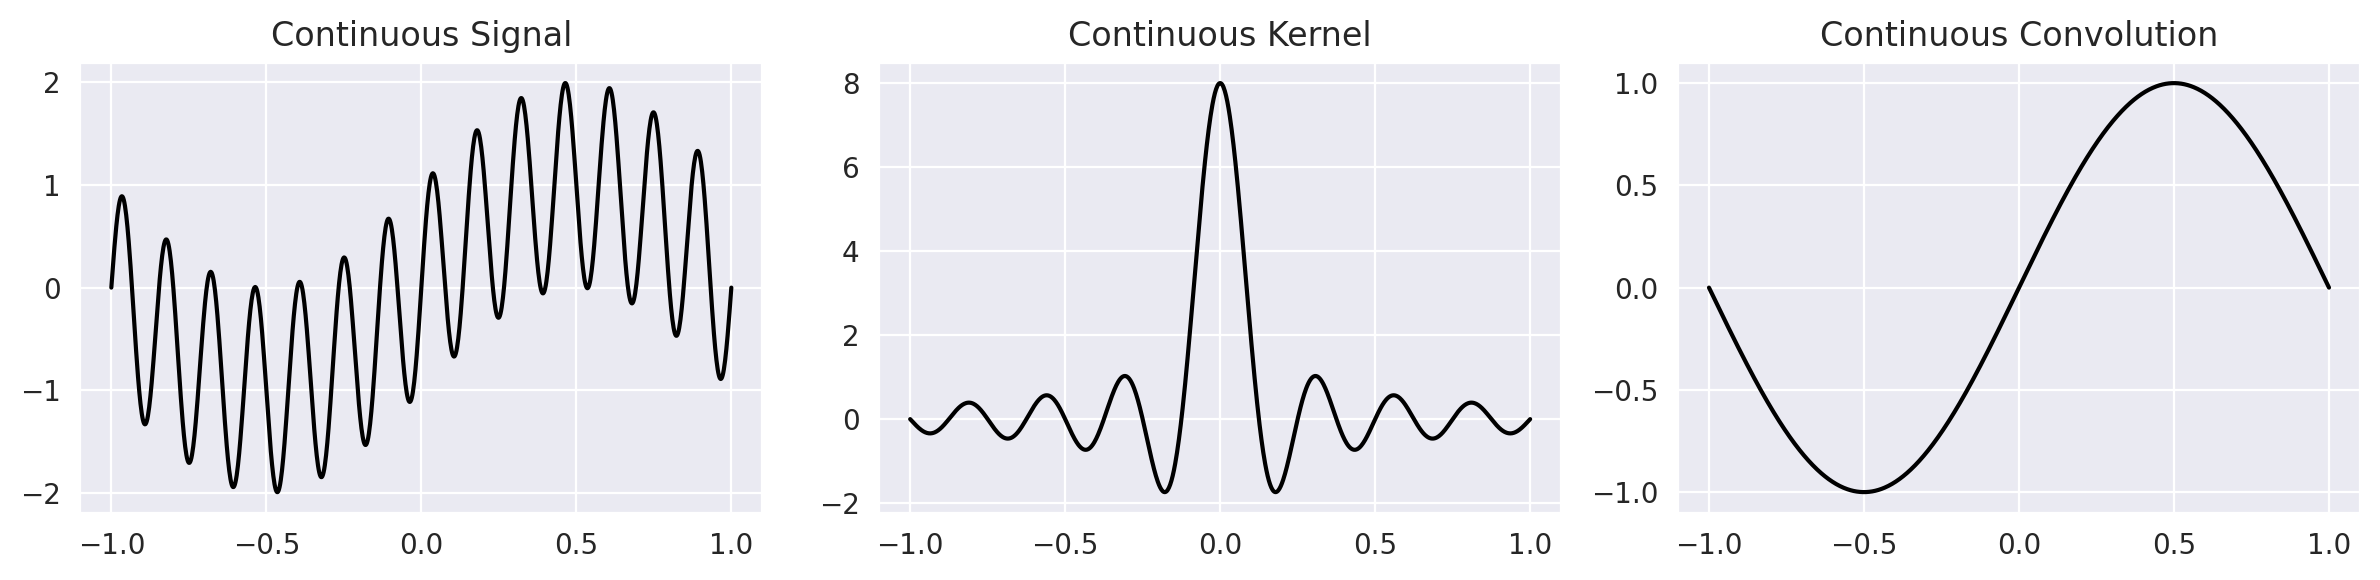

In [5]:
fig, ax = plt.subplots(1,3, figsize=(12,3), dpi=200)

for a in ax:
    a.set_xticks([-1, -0.5, 0, 0.5, 1])
    a.set_xlim(-1.1, 1.1)

ax[0].plot(x_cts,total_sig, color='black')
ax[0].set_title(label='Continuous Signal')

ax[1].plot(x_cts,ideal_filt, color='black')
ax[1].set_title(label='Continuous Kernel')

ax[2].plot(x_cts,analytic_result, color='black')
ax[2].set_title(label='Continuous Convolution')

fig.tight_layout()

In [6]:
fig.savefig("./convolution-continuous.pdf")

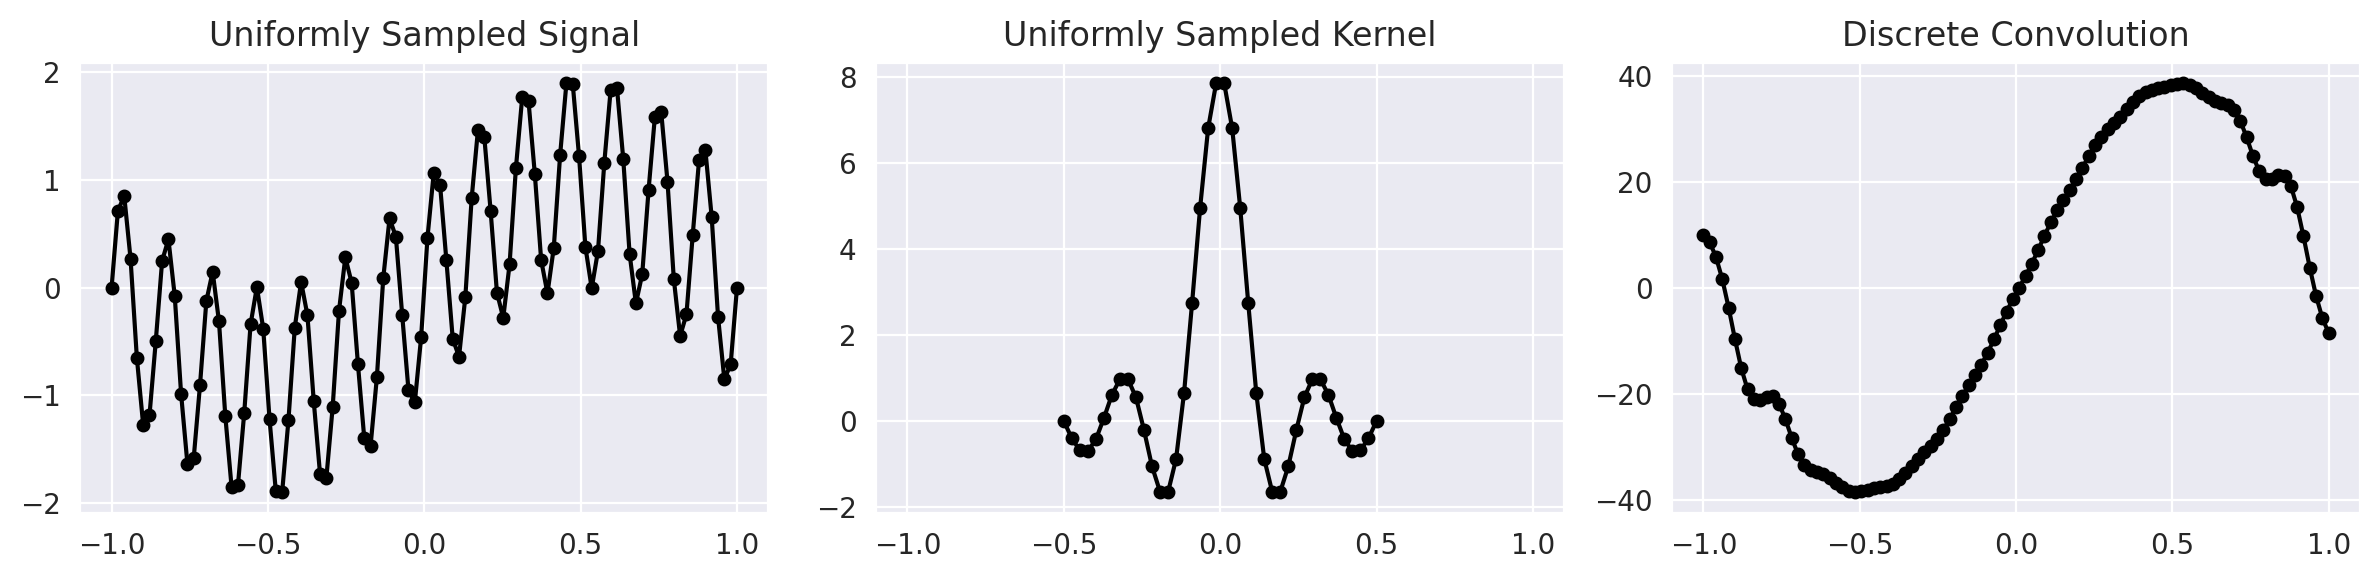

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12,3), dpi=200)

for a in ax:
    a.set_xticks([-1, -0.5, 0, 0.5, 1])
    a.set_xlim(-1.1, 1.1)
        
ax[0].plot(sampled, sampled_total, color='black', marker='.', ms=ms, mfc=mfc)
ax[0].set_title(label='Uniformly Sampled Signal')

ax[1].plot(sampled_small, sampled_filt, color='black', marker='.', ms=ms, mfc=mfc)
ax[1].set_title(label='Uniformly Sampled Kernel')

ax[2].plot(sampled, sampled_result, color='black', marker='.', ms=ms, mfc=mfc)
ax[2].set_title(label='Discrete Convolution')

fig.tight_layout()

In [8]:
fig.savefig("./convolution-uniform.pdf")

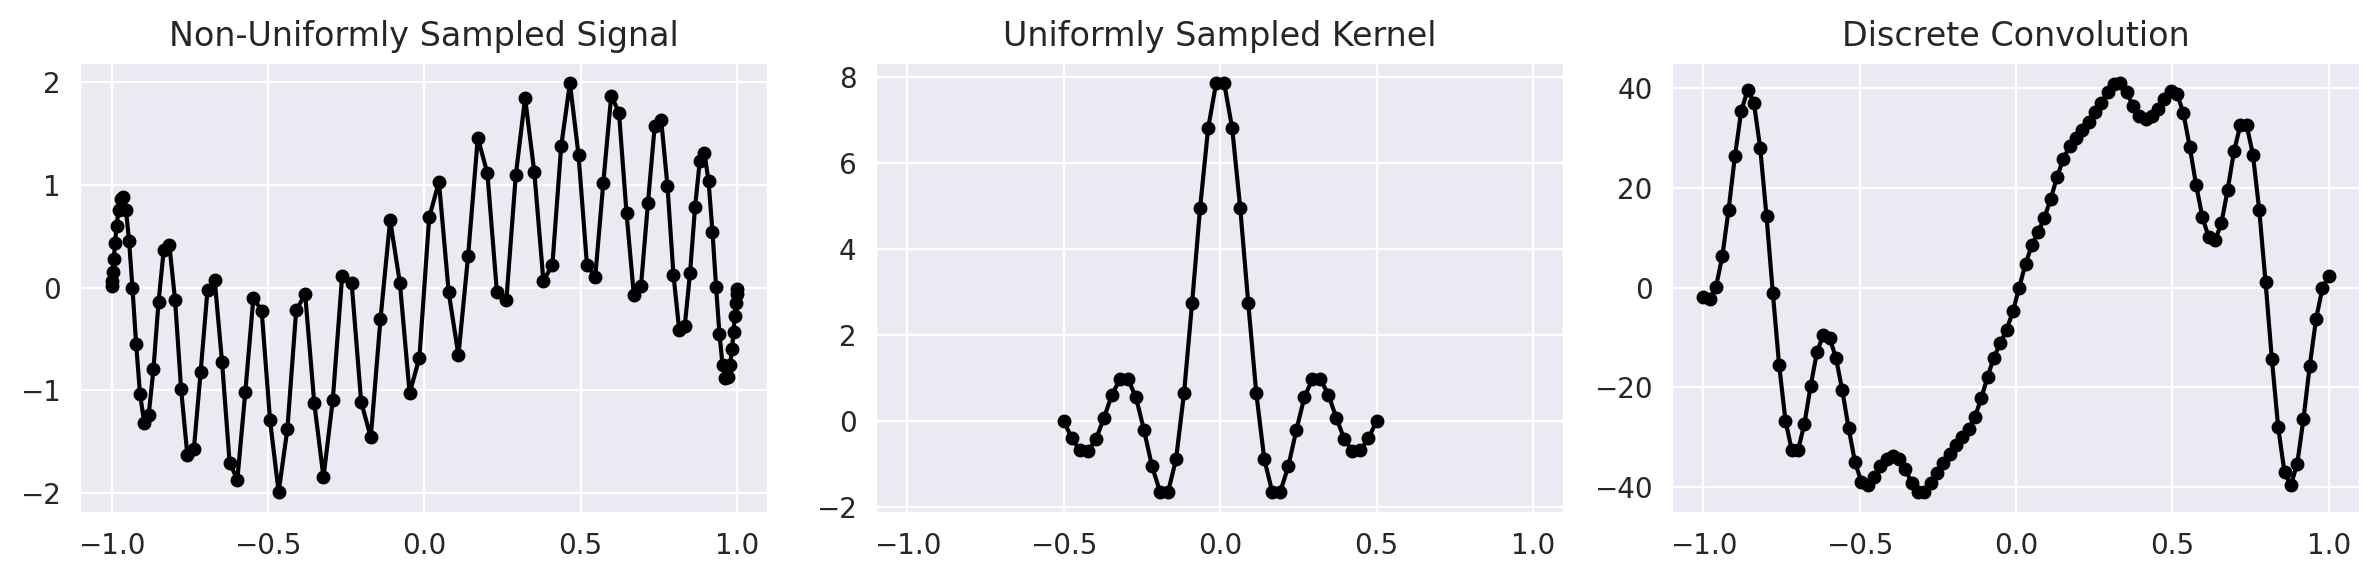

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12,3), dpi=200)

for a in ax:
    a.set_xticks([-1, -0.5, 0, 0.5, 1])
    a.set_xlim(-1.1, 1.1)
        
ax[0].plot(quad_nodes, qsampled_total, color='black', marker='.', ms=ms, mfc=mfc)
ax[0].set_title(label='Non-Uniformly Sampled Signal')

# ax[1].plot(quad_nodes, qsampled_filt, color='black', marker='.', ms=ms, mfc=mfc)
# ax[1].set_title(label='Unstructured Kernel')

# ax[2].plot(quad_nodes, qsampled_result, color='black', marker='.', ms=ms, mfc=mfc)
# ax[2].set_title(label='Discrete Convolution')

ax[1].plot(sampled_small, sampled_filt, color='black', marker='.', ms=ms, mfc=mfc)
ax[1].set_title(label='Uniformly Sampled Kernel')

ax[2].plot(sampled, us_and_st, color='black', marker='.', ms=ms, mfc=mfc)
ax[2].set_title(label='Discrete Convolution')

fig.tight_layout()

In [10]:
fig.savefig("./convolution-mixed.pdf")

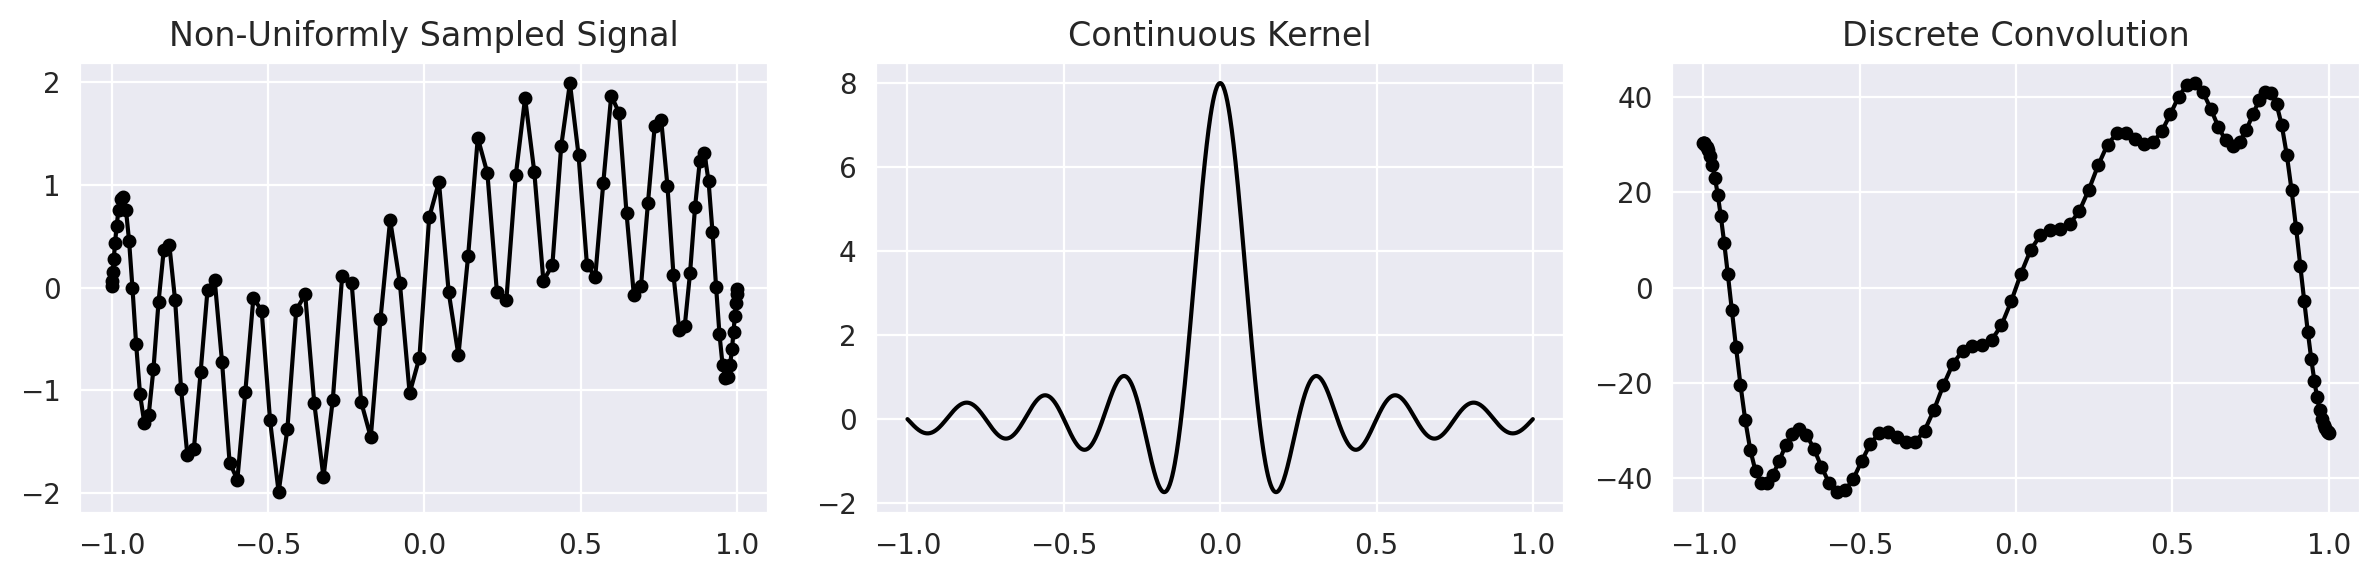

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12,3), dpi=200)

for a in ax:
    a.set_xticks([-1, -0.5, 0, 0.5, 1])
    a.set_xlim(-1.1, 1.1)
        
ax[0].plot(quad_nodes, qsampled_total, color='black', marker='.', ms=ms, mfc=mfc)
ax[0].set_title(label='Non-Uniformly Sampled Signal')

ax[1].plot(x_cts, ideal_filt, color='black')
ax[1].set_title(label='Continuous Kernel')

ax[2].plot(quad_nodes, no_weights, color='black', marker='.', ms=ms, mfc=mfc)
ax[2].set_title(label='Discrete Convolution')

fig.tight_layout()

In [12]:
fig.savefig("./convolution-nonuniform.pdf")

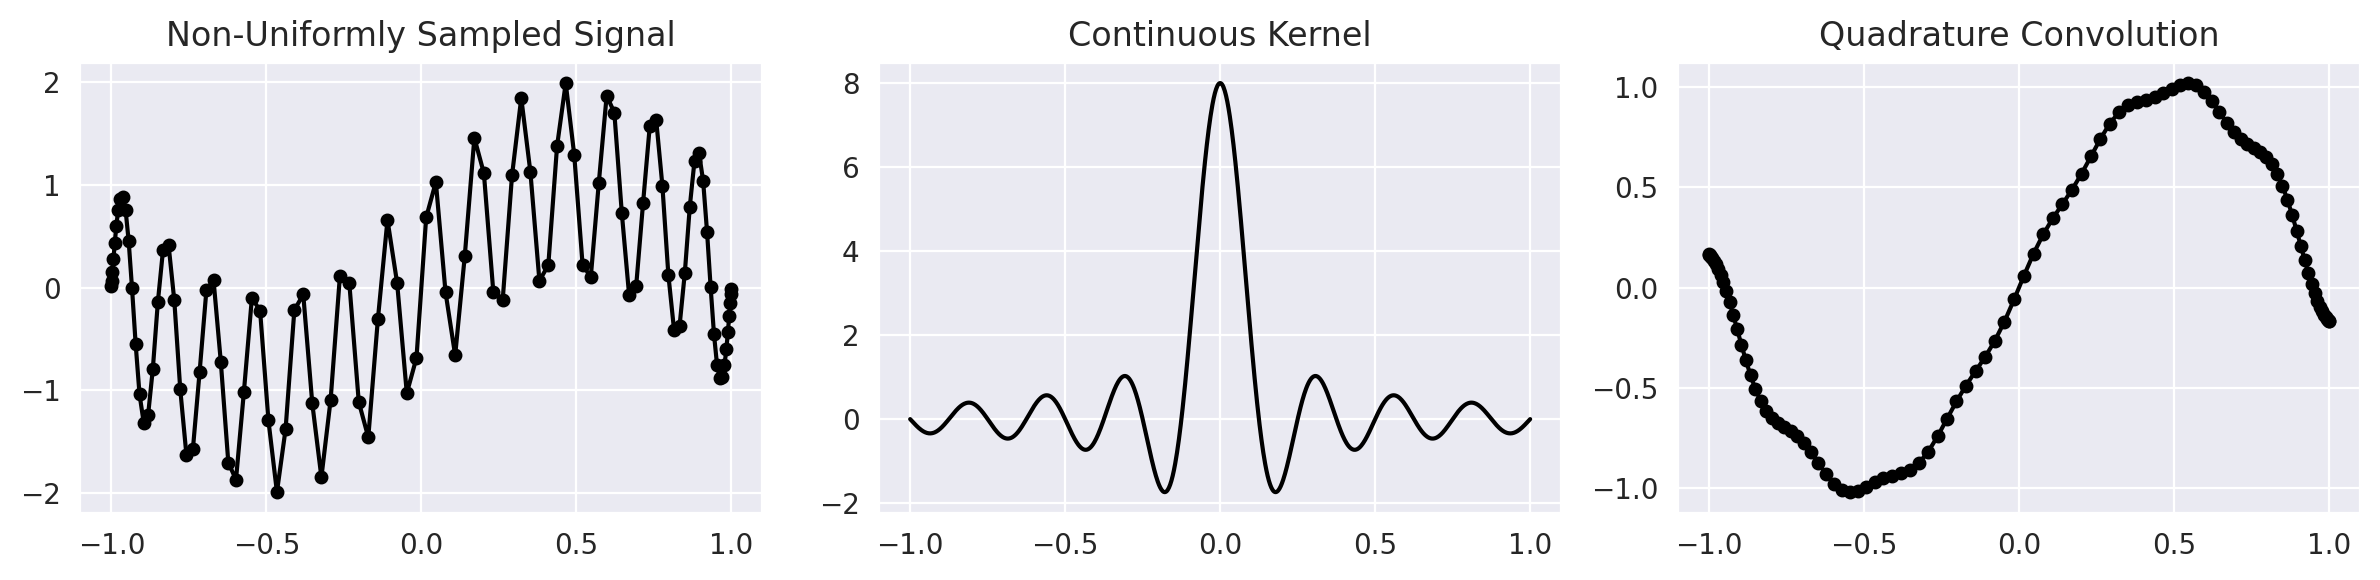

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,3), dpi=200)

for a in ax:
    a.set_xticks([-1, -0.5, 0, 0.5, 1])
    a.set_xlim(-1.1, 1.1)
        
ax[0].plot(quad_nodes, qsampled_total, color='black', marker='.', ms=ms, mfc=mfc)
ax[0].set_title(label='Non-Uniformly Sampled Signal')

ax[1].plot(x_cts, ideal_filt, color='black')
ax[1].set_title(label='Continuous Kernel')

ax[2].plot(quad_nodes, our_way, color='black', marker='.', ms=ms, mfc=mfc)
ax[2].set_title(label='Quadrature Convolution')

fig.tight_layout()

In [14]:
fig.savefig("./convolution-quadrature.pdf")